Loading Data In

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from IPython.display import display, HTML

# Read the CSV files into DataFrames
df1 = pd.read_csv('questionnaire.csv')
df2 = pd.read_csv('demographic.csv')
df3 = pd.read_csv('diet.csv')
df4 = pd.read_csv('examination.csv')

# Merge the DataFrames on the 'seqn' column
df = df1.merge(df2, on='SEQN').merge(df3, on='SEQN').merge(df4, on='SEQN')

# Print the merged DataFrame
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df.shape)


(10175, 953)
(10175, 47)
(9813, 168)
(9813, 224)
(9813, 1389)


In [34]:
# List of columns to keep
columns_to_keep = [
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXSY1', 'BPXSY2', 'BPXSY3', 'BMXBMI', 'BMXHT', 'BMXWAIST', 'BMXWT', 'BPQ080',
    'DRQSDIET', 'DRQSPREP', 'MCQ010', 'MCQ160F', 'CDQ001', 'OCQ210', 'DIQ010', 'DIQ160',
    'PAQ650', 'PAQ665', 'DPQ050', 'DPQ040', 'DPQ030', 'DPQ020','ALQ101','ALQ151', 'ALQ120Q', 'ALQ130', 'SMQ020', 'SMQ040', 'DBQ700', 'HSD010', 'SLD010H'
]

# Drop all columns except for the specified ones
df = df[columns_to_keep]

# Drop all rows where RIDAGEYR is less than 18
df = df[df['RIDAGEYR'] >= 18]

df.head()

,SEQN,RIAGENDR,RIDAGEYR,DMDEDUC2,BPXDI1,BPXDI2,BPXDI3,BPXSY1,BPXSY2,BPXSY3,...,DPQ020,ALQ101,ALQ151,ALQ120Q,ALQ130,SMQ020,SMQ040,DBQ700,HSD010,SLD010H
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,0.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,7.0
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,0.0,1.0,1.0,7.0,4.0,1.0,2.0,3.0,4.0,9.0
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,0.0,1.0,2.0,0.0,NaN,1.0,3.0,3.0,3.0,8.0
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,1.0,1.0,2.0,0.0,NaN,2.0,NaN,2.0,5.0,9.0
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,3.0,1.0,2.0,5.0,1.0,1.0,3.0,5.0,5.0,5.0


In [35]:
# Filling Nulls Due to Skip Questions
df.loc[df['ALQ101'] == 2, ['ALQ120Q', 'ALQ130']] = df.loc[df['ALQ101'] == 2, ['ALQ120Q', 'ALQ130']].fillna(0)
df.loc[df['ALQ101'] == 2, ['ALQ151']] = df.loc[df['ALQ101'] == 2, ['ALQ151']].fillna(2)

df.loc[df['SMQ020'] != 1, ['SMQ040']] = df.loc[df['SMQ020'] != 1, ['SMQ040']].fillna(3)

df.loc[df['ALQ120Q'] <= 3, ['ALQ130']] = df.loc[df['ALQ120Q'] <= 3, ['ALQ130']].fillna(0)

In [36]:
# Rename the columns as specified
new_column_names = {
    'SEQN': 'ID',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age',
    'BPXDI1': 'DiasBP1',
    'BPXDI2': 'DiasBP2',
    'BPXDI3': 'DiasBP3',
    'BPXSY1': 'SysBP1',
    'BPXSY2': 'SysBP2',
    'BPXSY3': 'SysBP3',
    'BMXBMI': 'BMI',
    'BMXHT': 'Height',
    'BMXWAIST': 'Waist',
    'BMXWT': 'Weight',
    'BPQ080': 'Cholesterol',
    'DRQSDIET': 'Diet',
    'DRQSPREP': 'SaltFreq',
    'MCQ010': 'Asthma',
    'MCQ160F': 'Stroke',
    'PAQ650': 'VigActivity',
    'PAQ665': 'ModActivity',
    'DPQ050': 'FeelPoorEating',
    'DPQ040': 'FeelTired',
    'DPQ030': 'SleepTroubles',
    'DPQ020': 'FeelDepressed',
    'ALQ151': 'AlcConsumpMoreThan4/5MostDays',
    'ALQ120Q': 'AlcConsumpFreq',
    'ALQ130': 'AlcConsumpAmtPerDrinkDay',
    'SMQ020': '100Cigs',
    'DBQ700': 'OvrDietHealth',
    'HSD010': 'GenHealth',
    'SLD010H': 'SleepDuringWork',
    'SMQ040': 'Smoker',
    'DMDEDUC2': 'EducationLvl',
    'DIQ010' : 'Diabetes',
    'DIQ160' : 'Prediabetic'
}

df.rename(columns=new_column_names, inplace=True)

# Show the first few rows to verify the changes
df.head()

,ID,Gender,Age,EducationLvl,DiasBP1,DiasBP2,DiasBP3,SysBP1,SysBP2,SysBP3,...,FeelDepressed,ALQ101,AlcConsumpMoreThan4/5MostDays,AlcConsumpFreq,AlcConsumpAmtPerDrinkDay,100Cigs,Smoker,OvrDietHealth,GenHealth,SleepDuringWork
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,0.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,7.0
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,0.0,1.0,1.0,7.0,4.0,1.0,2.0,3.0,4.0,9.0
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,0.0,1.0,2.0,0.0,0.0,1.0,3.0,3.0,3.0,8.0
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,1.0,1.0,2.0,0.0,0.0,2.0,3.0,2.0,5.0,9.0
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,3.0,1.0,2.0,5.0,1.0,1.0,3.0,5.0,5.0,5.0


## Feature Descriptions

### Cholesterol
- **Question:** Do you suffer from high cholesterol?

### Diet
- **Question:** Are you on a diet?

### Salt Frequency
- **Question:** How often do you add salt to your food?
  - 1 = Never
  - 2 = Rarely
  - 3 = Occasionally
  - 4 = Very Often

### Asthma
- **Question:** Have you ever been told you have asthma? (Refer to MCQ035 to check if you still have it)

### Stroke
- **Question:** Have you ever had a stroke?

### Vigorous Activity
- **Question:** Do you engage in any vigorous activity?

### Moderate Activity
- **Question:** Do you engage in any moderate activity?

### Over the Last 2 Weeks...
- **FeelPoorEating:** Have you been bothered by poor eating or appetite?
- **FeelTired:** Have you felt tired?
- **SleepTroubles:** Have you struggled to fall asleep, stay asleep, or slept too much?
- **FeelDepressed:** Have you felt depressed?

### Alcohol Consumption
- **AlcConsumpMoreThan4/5MostDays:** Have you ever consumed more than 4/5 drinks on most days?
- **AlcConsumpFreq:** How many days have you consumed alcohol in the past year?
- **AlcConsumpAmtPerDrinkDay:** On days you drank in the last year, on average, how many drinks did you have?

### Smoking
- **SMD030:** Age started smoking regularly (skip if < 100 cigs)
  - 7-64
  - 0 = Never regular
  - 80 = 80+
- **Smoker:** Do you currently smoke?
  - 1 = Every day
  - 2 = Some days
  - 3 = Never
- **SMQ050Q:** How long since you quit? (Skip if smoker = 1/2)
- **SMD055:** Age last smoked regularly (skip if still smokes/< 100 cigs)
- **SMD057:** When did you smoke, how many? (Skip if still smokes/< 100 cigs)
  - 1-90
  - 95+
- **SMD641:** Days smoked in the past 30 days (skip if not a current smoker)
- **SMD650:** Average number of cigarettes per day in the past 30 days (skip if not a current smoker)

### Overall Diet Health
- **Question:** How would you rate the health of your diet?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### General Health
- **Question:** How would you rate your general health condition?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### Sleep During Work Days
- **Question:** How much sleep do you get during work days?
  - 2-11 hours
  - 12 = 12+ hours

### Education Level
- **Question:** What is the highest level of school that you have completed?
  - 1 = Less than grade 9
  - 2 = Less than matriculated
  - 3 = High school graduate
  - 4 = Some college degree
  - 5 = College graduate or higher

### Diabetes
- **Question:** Has a doctor ever told you that you have diabetes?
  - 1 = Yes
  - 2 = No
  - 3 = Borderline

### Prediabetic
- **Question:** Has a doctor ever told you that you are prediabetic?


In [37]:
df.head()

,ID,Gender,Age,EducationLvl,DiasBP1,DiasBP2,DiasBP3,SysBP1,SysBP2,SysBP3,...,FeelDepressed,ALQ101,AlcConsumpMoreThan4/5MostDays,AlcConsumpFreq,AlcConsumpAmtPerDrinkDay,100Cigs,Smoker,OvrDietHealth,GenHealth,SleepDuringWork
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,0.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,7.0
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,0.0,1.0,1.0,7.0,4.0,1.0,2.0,3.0,4.0,9.0
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,0.0,1.0,2.0,0.0,0.0,1.0,3.0,3.0,3.0,8.0
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,1.0,1.0,2.0,0.0,0.0,2.0,3.0,2.0,5.0,9.0
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,3.0,1.0,2.0,5.0,1.0,1.0,3.0,5.0,5.0,5.0


## Data Exploration

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_distribution(dataframe, columns, threshold=7):
    # Loop through each specified column (feature) in the columns list
    for column in columns:
        # Check if the column exists in the dataframe
        if column in dataframe.columns:
            # Filter the data to include only values smaller than the threshold and skip null values
            filtered_data = dataframe[column].dropna()
            filtered_data = filtered_data[filtered_data < threshold]
            
            # Check if the filtered data is not empty and contains valid numerical values
            if not filtered_data.empty and filtered_data.min() != filtered_data.max():
                # Plot the histogram for the filtered data with narrower bars
                plt.figure(figsize=(8, 5))
                plt.hist(filtered_data, bins=range(int(filtered_data.min()), int(filtered_data.max()) + 2), 
                         alpha=0.7, color='blue', edgecolor='black', width=0.8)  # Adjust 'width' for narrower bars
                
                # Set titles and labels
                plt.title(f'Frequency Distribution of {column}')
                plt.xlabel(column)
                plt.ylabel('Frequency')
                
                # Show the plot
                plt.show()
            else:
                print(f"No valid data to plot for column '{column}'.")
        else:
            print(f"Column '{column}' not found in the dataframe.")


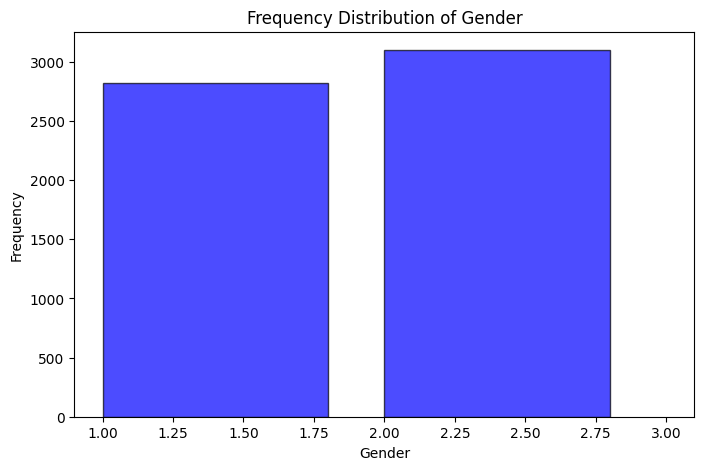

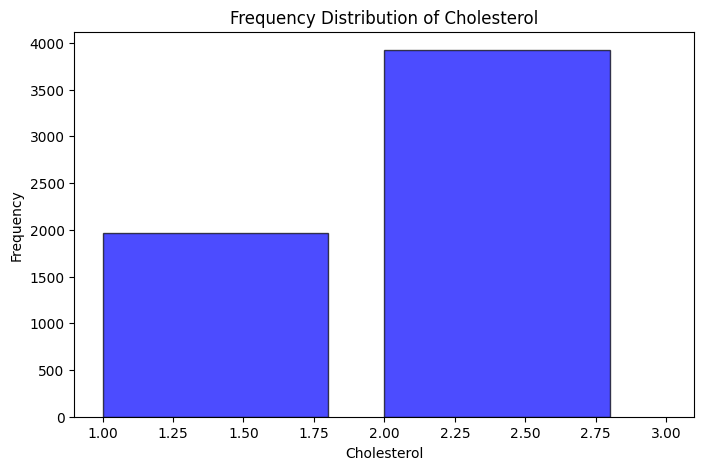

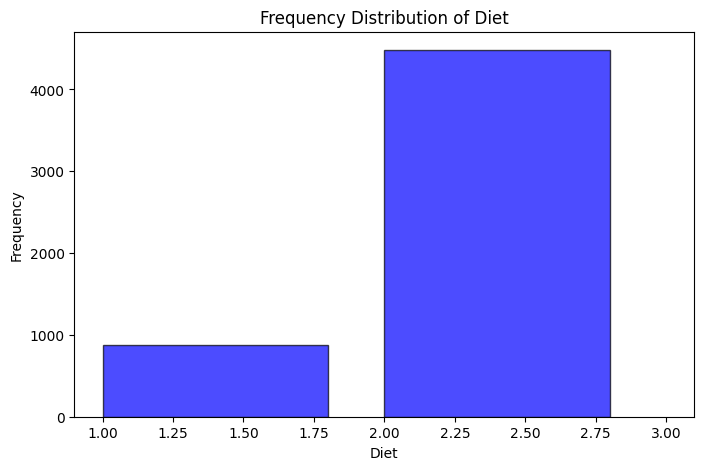

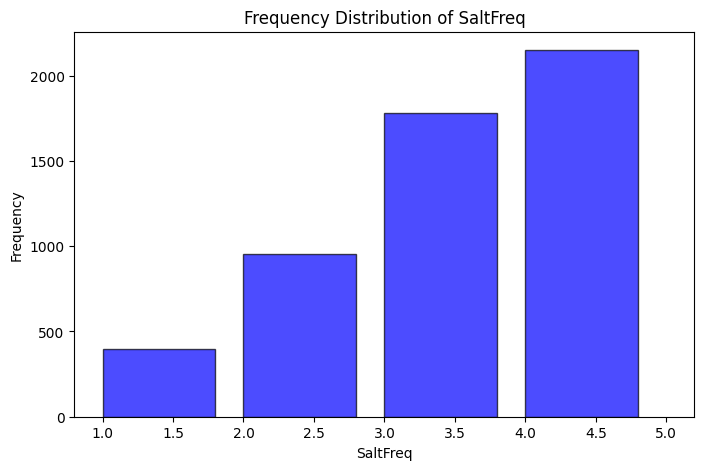

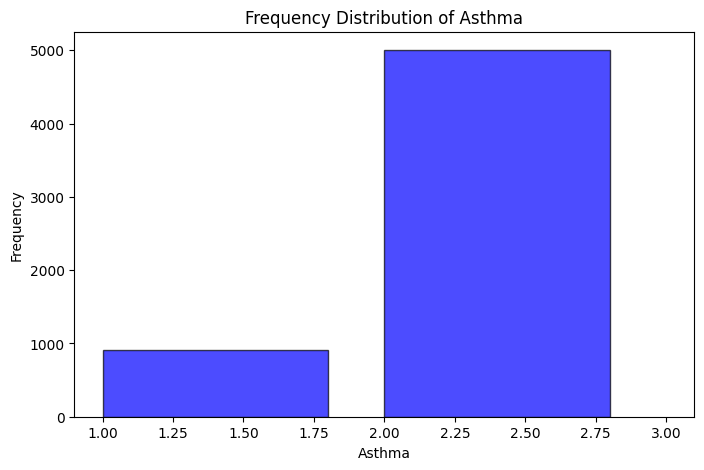

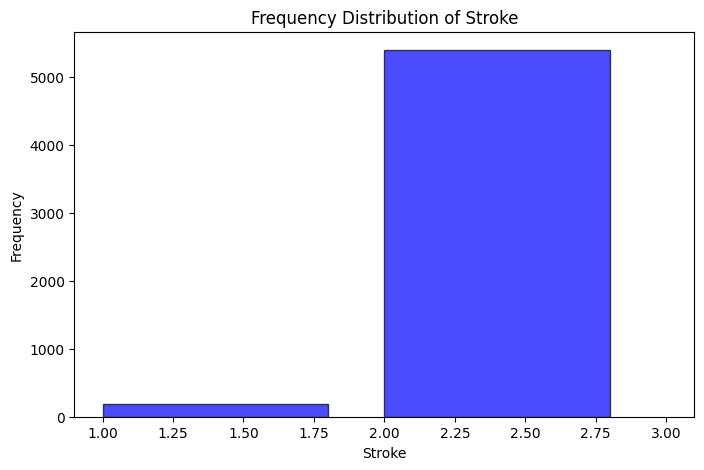

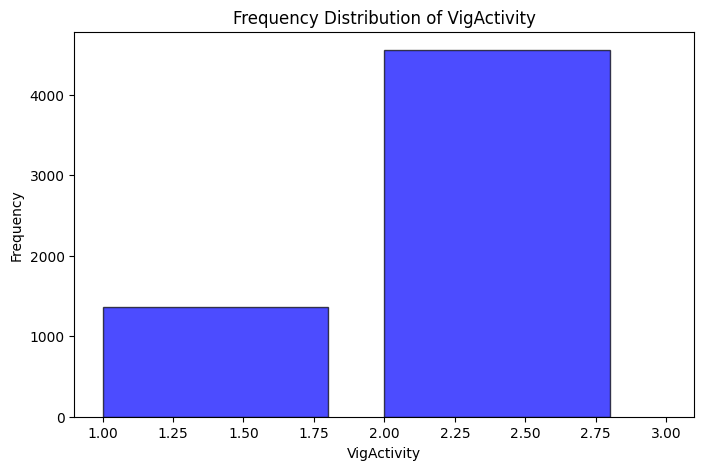

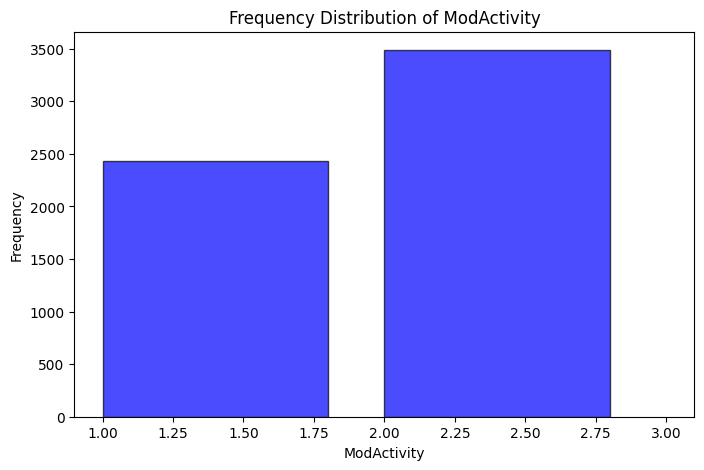

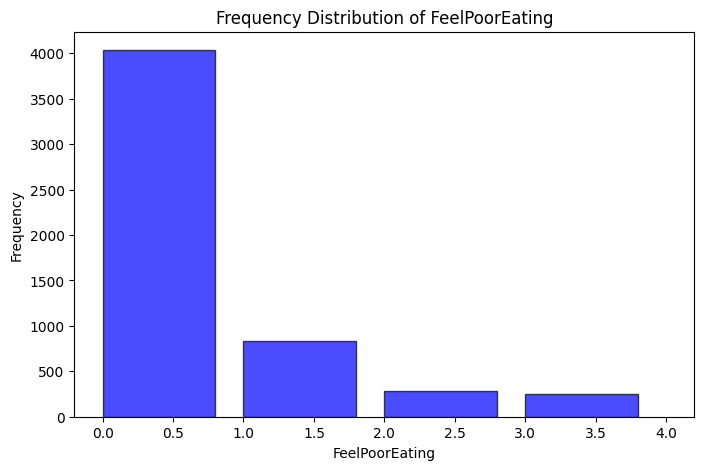

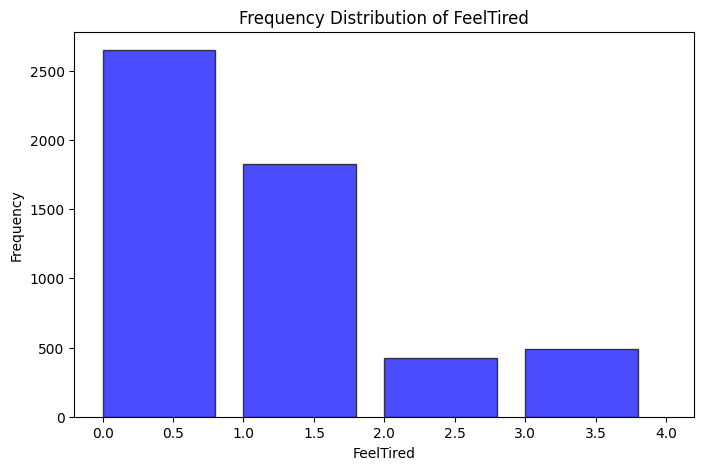

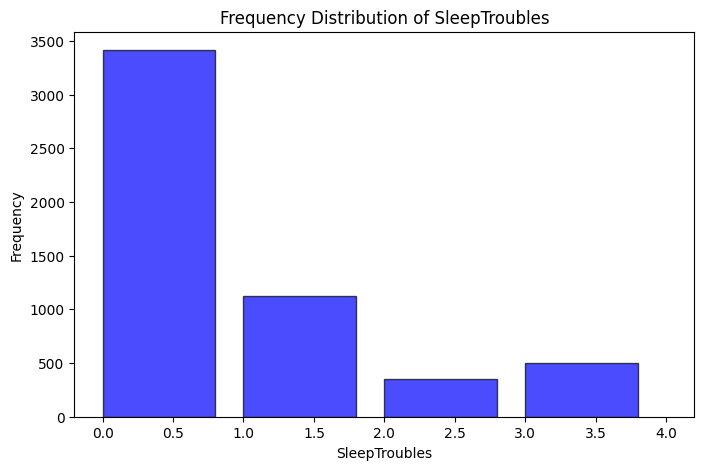

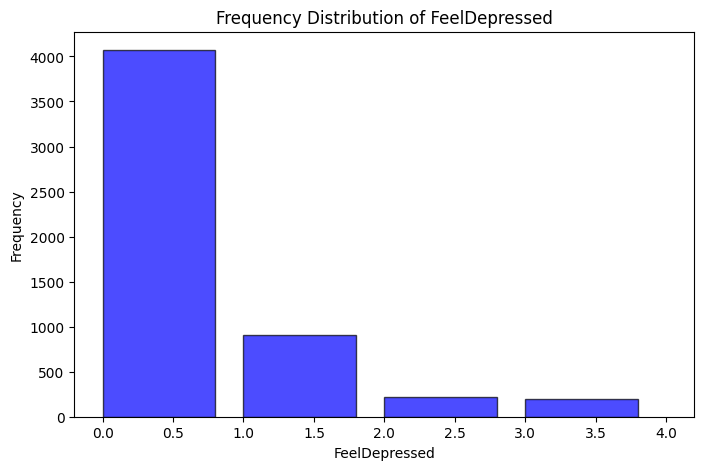

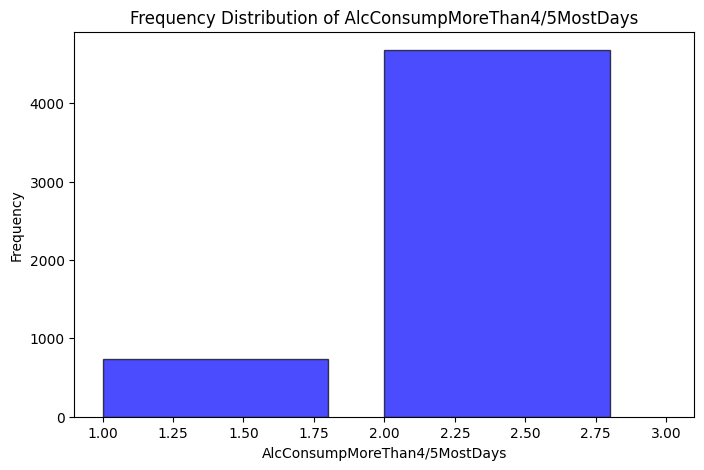

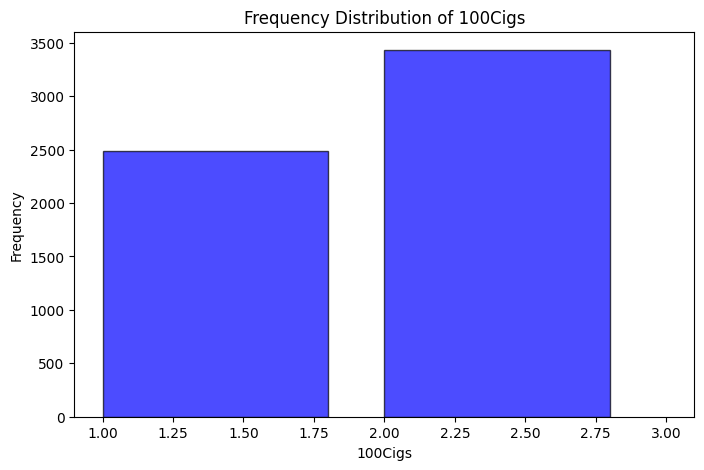

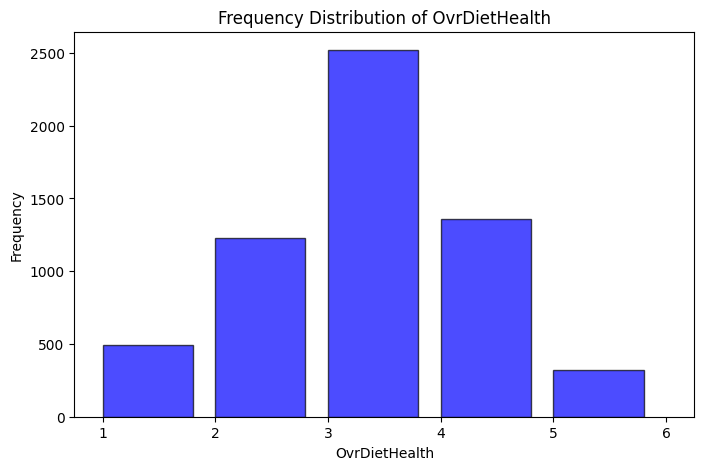

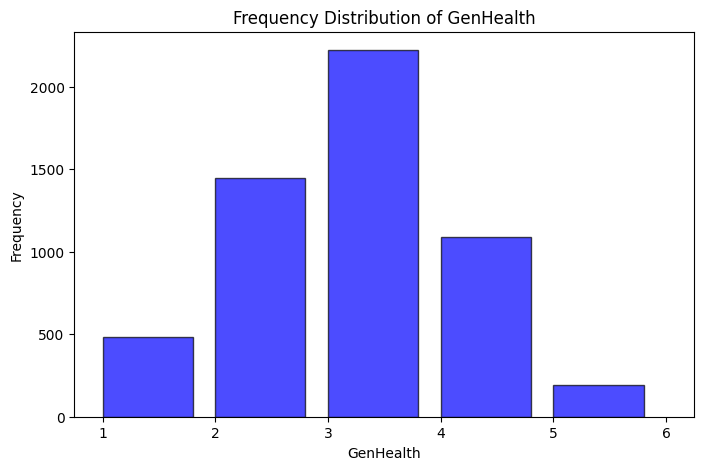

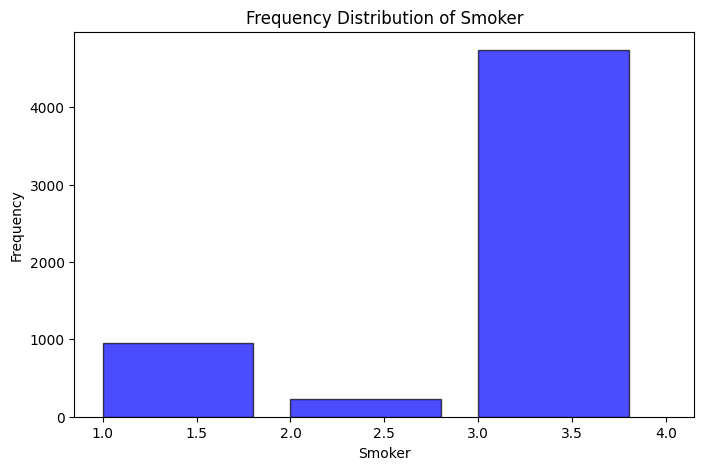

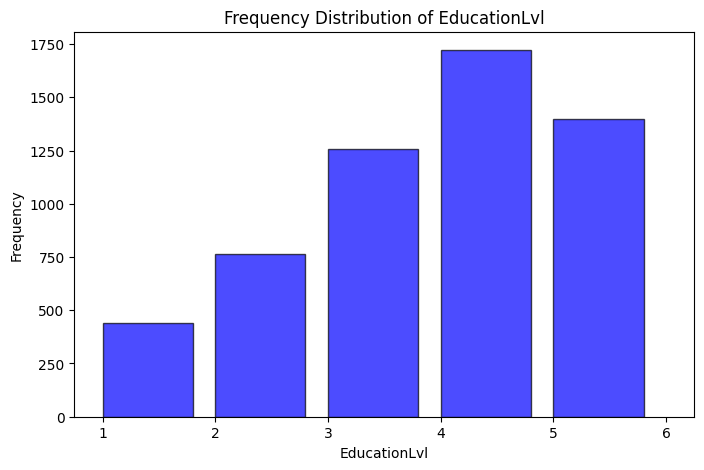

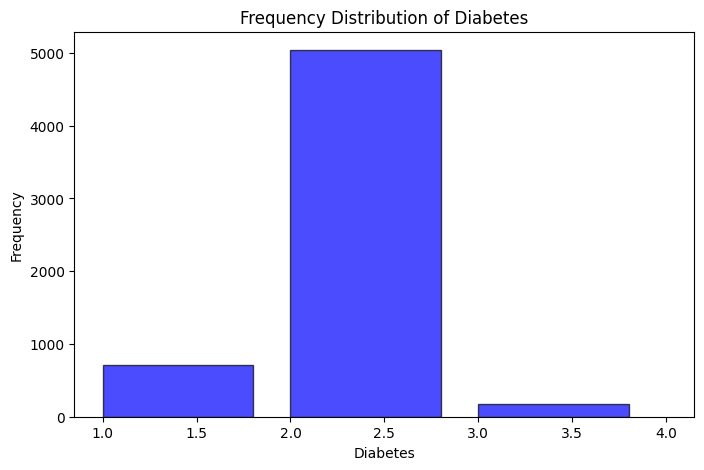

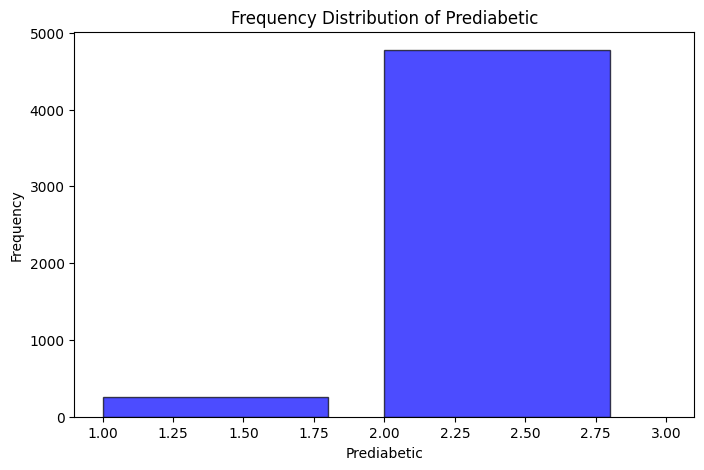

In [39]:
features_seven = ['Gender','Cholesterol','Diet','SaltFreq','Asthma', 'Stroke', 'VigActivity','ModActivity','FeelPoorEating','FeelTired','SleepTroubles','FeelDepressed','AlcConsumpMoreThan4/5MostDays','100Cigs','OvrDietHealth','GenHealth','Smoker','EducationLvl','Diabetes','Prediabetic']
plot_feature_distribution(df, features_seven)

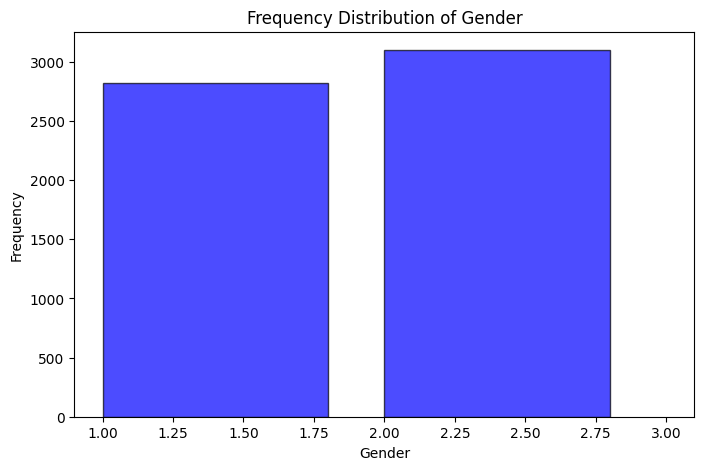

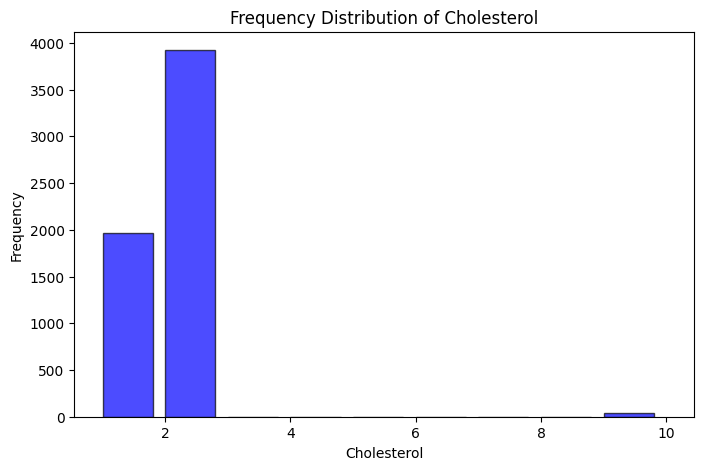

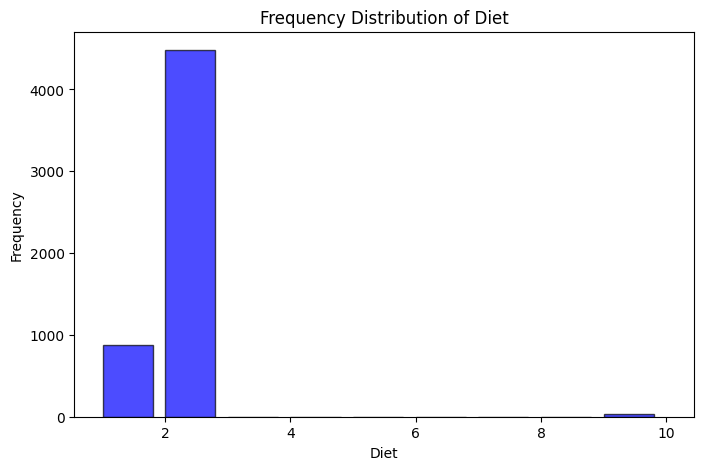

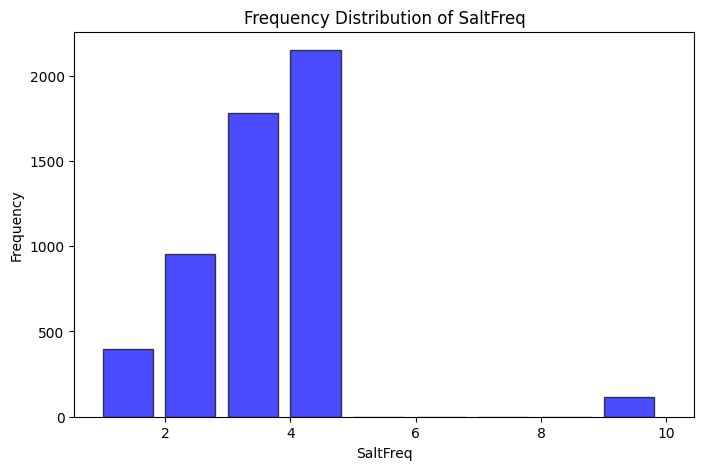

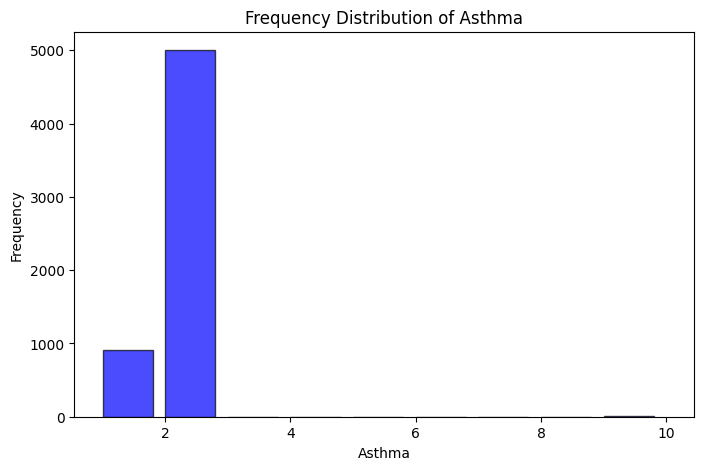

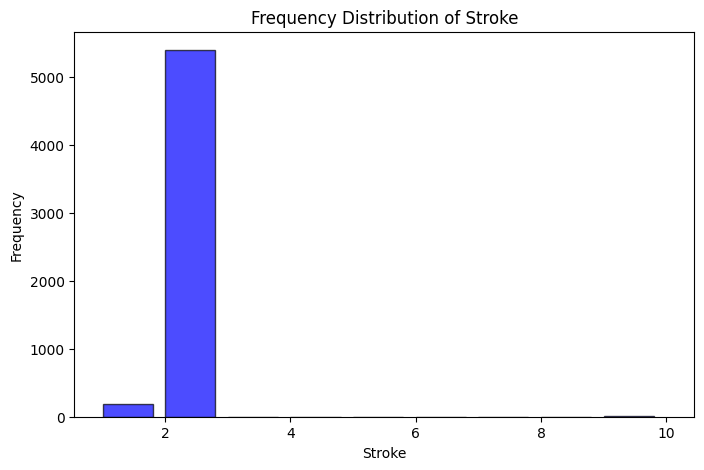

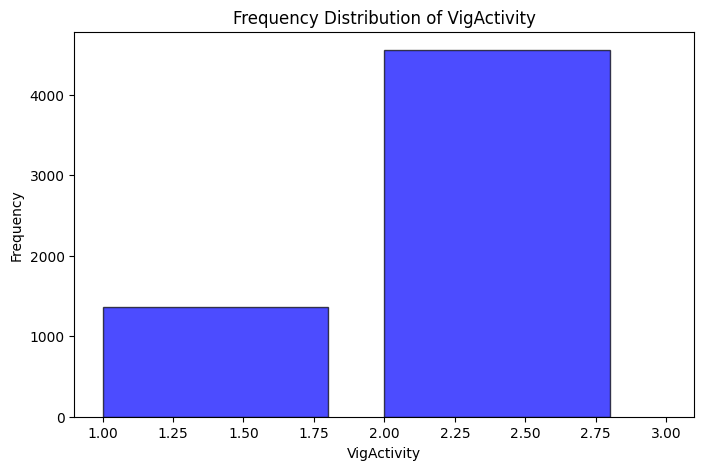

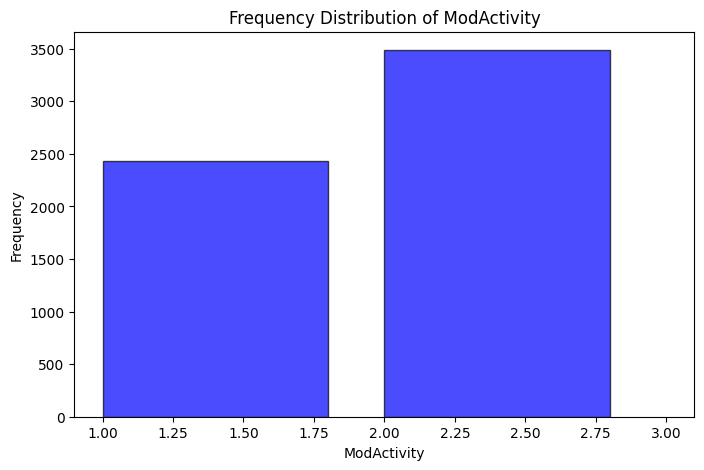

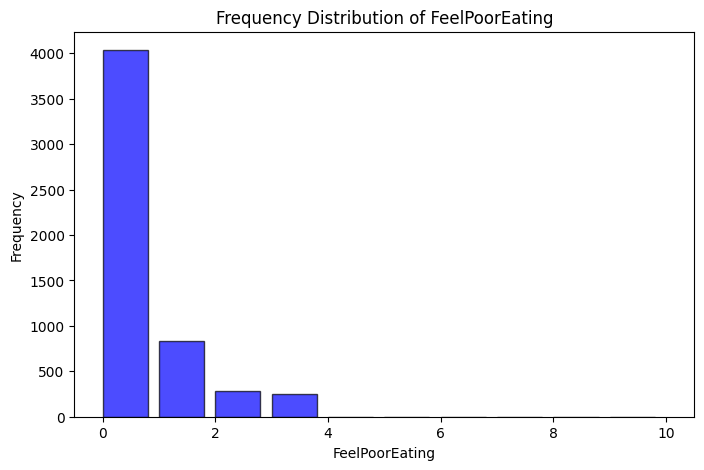

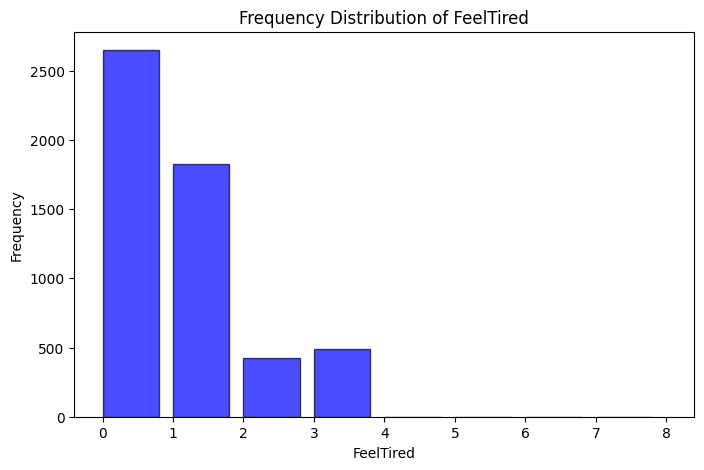

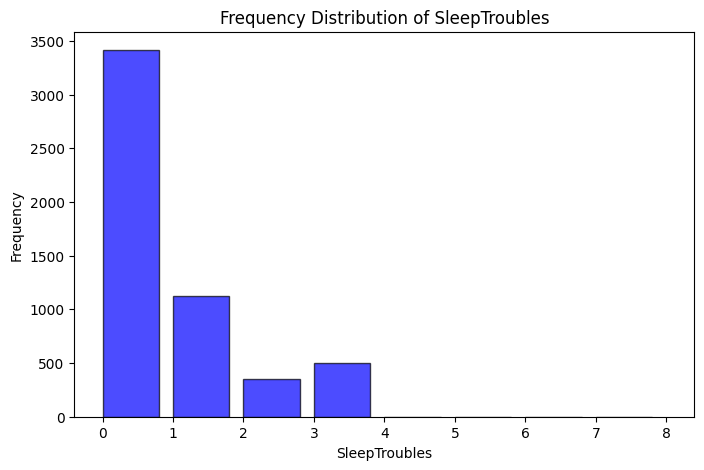

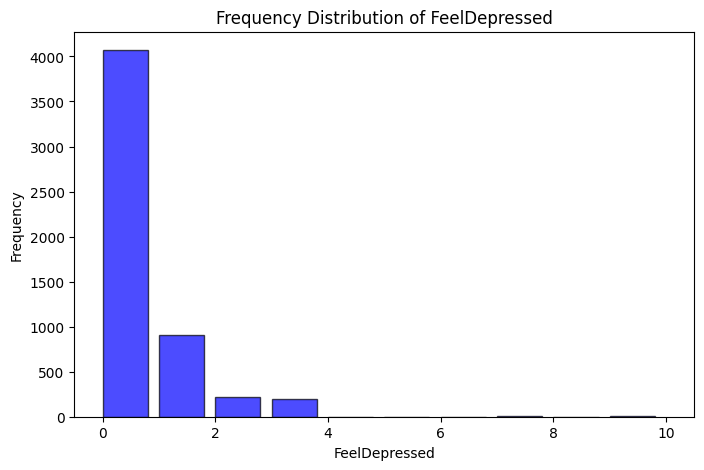

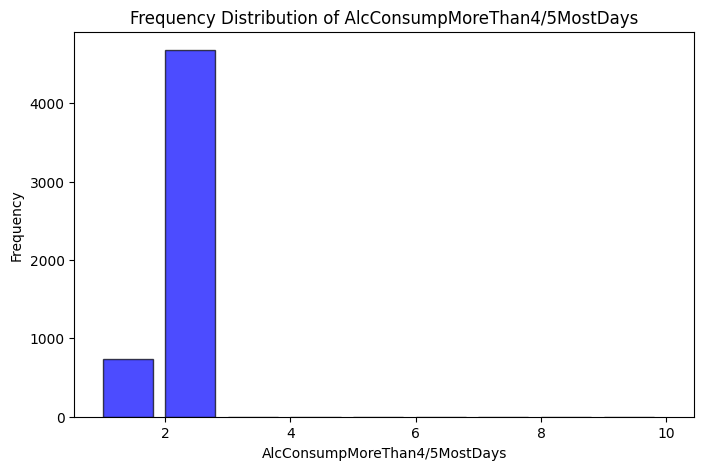

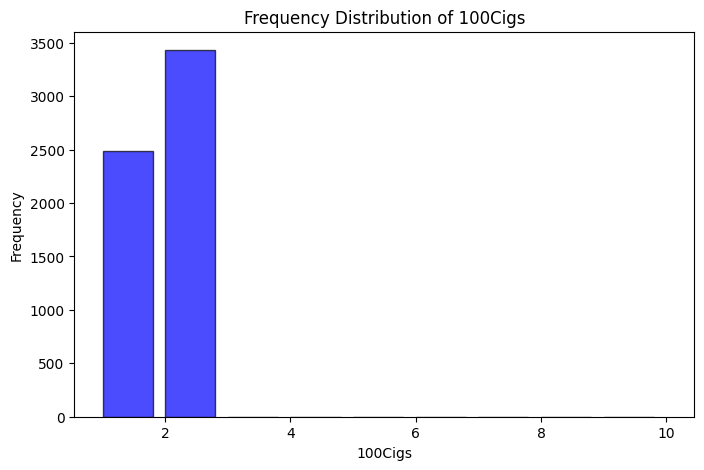

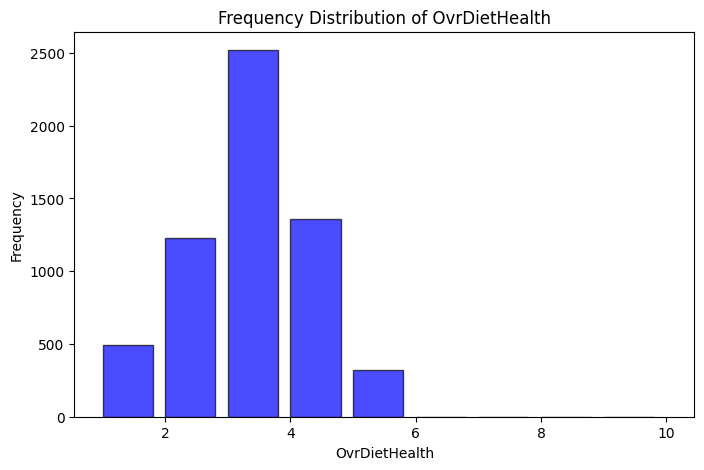

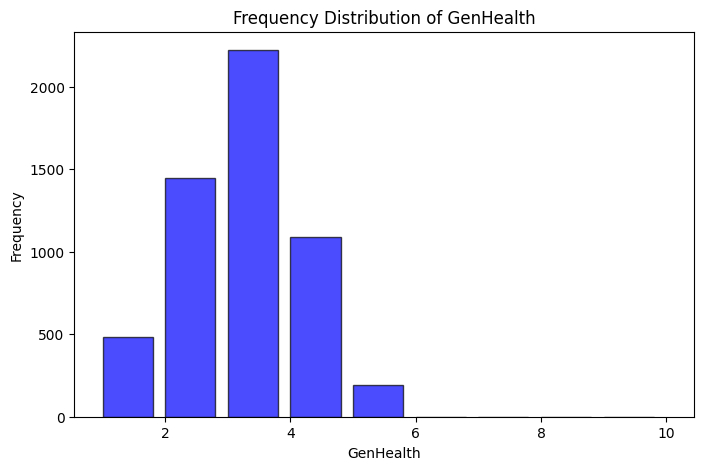

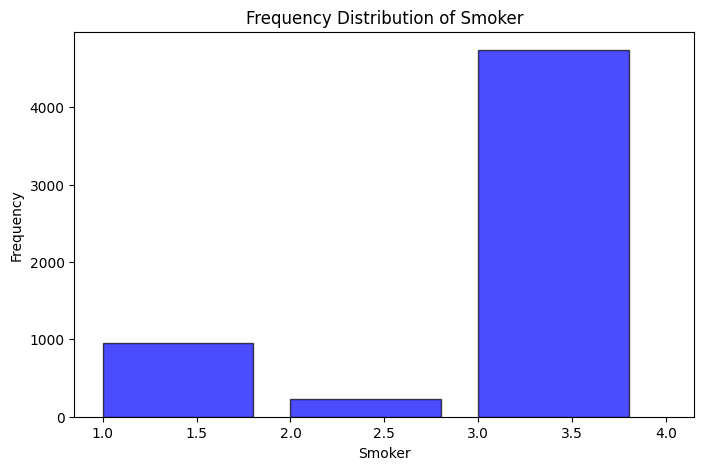

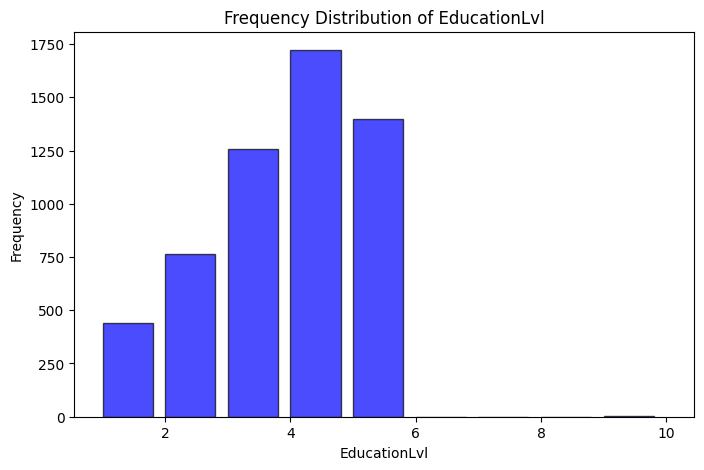

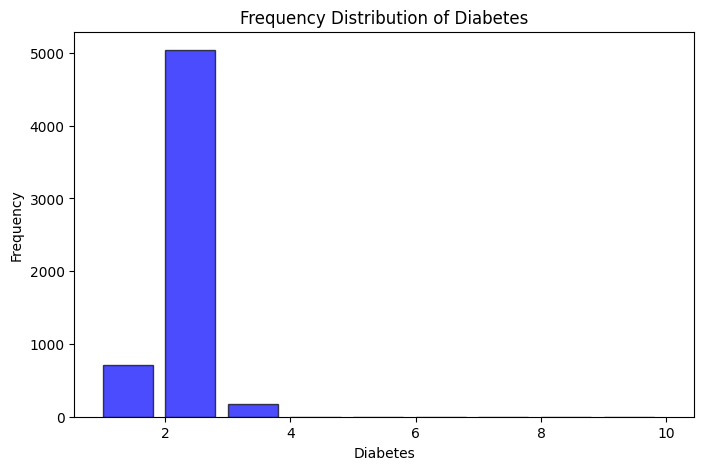

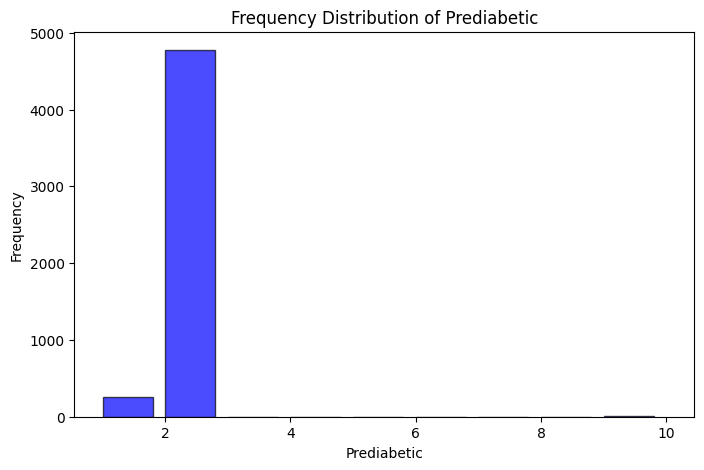

In [40]:
feature_seventy_seven = ['SleepDuringWork']
plot_feature_distribution(df, features_seven, 77)

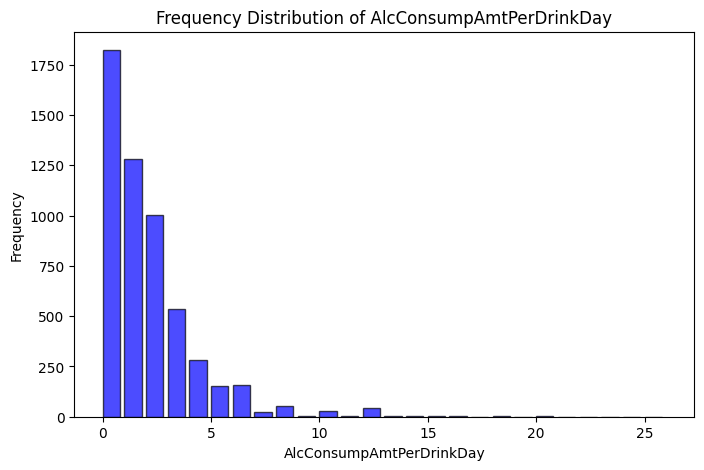

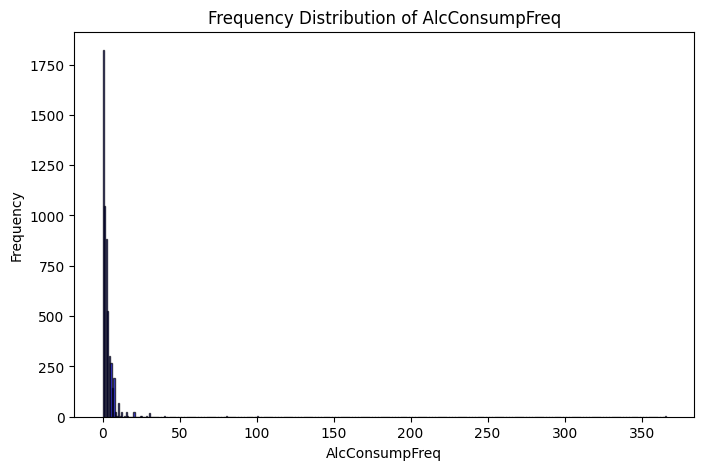

In [41]:
feature_seven_hundred = ['AlcConsumpAmtPerDrinkDay', 'AlcConsumpFreq']
plot_feature_distribution(df, feature_seven_hundred, 777)

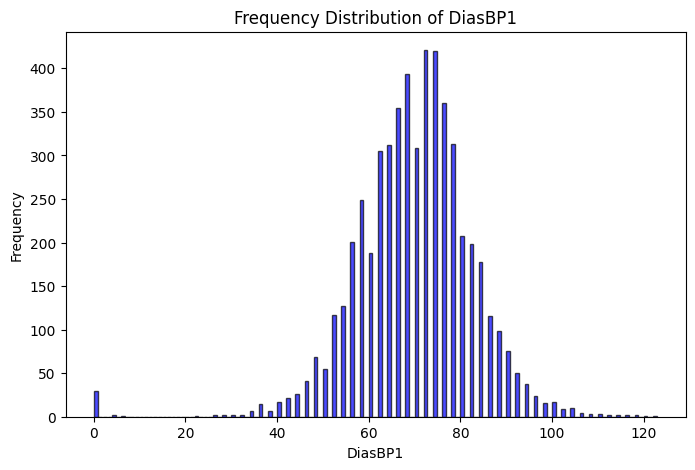

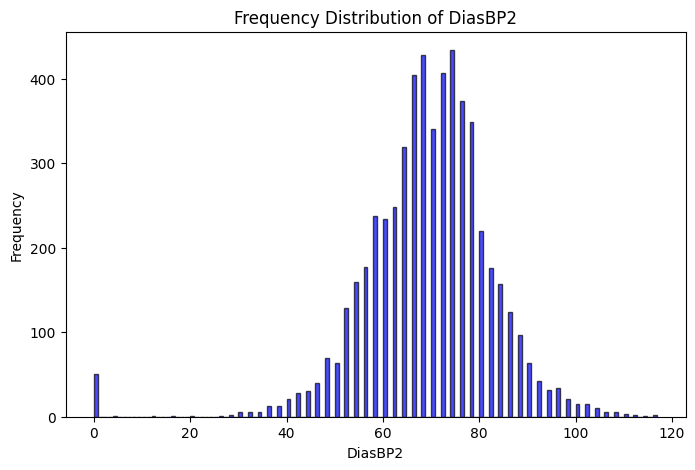

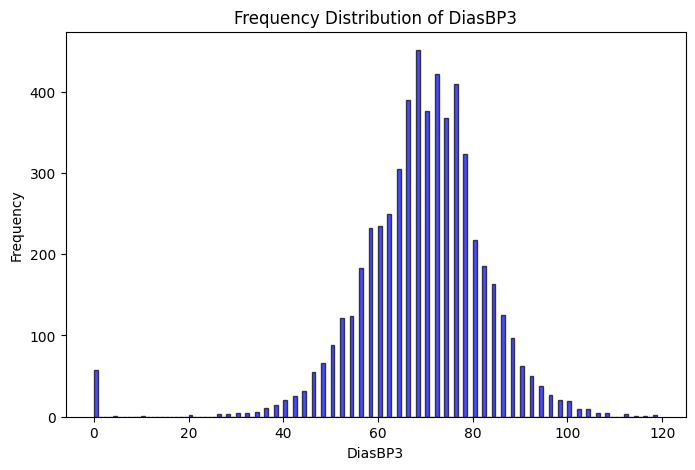

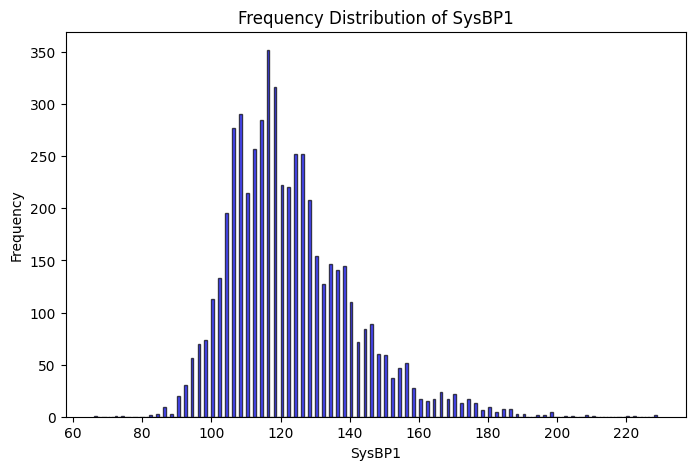

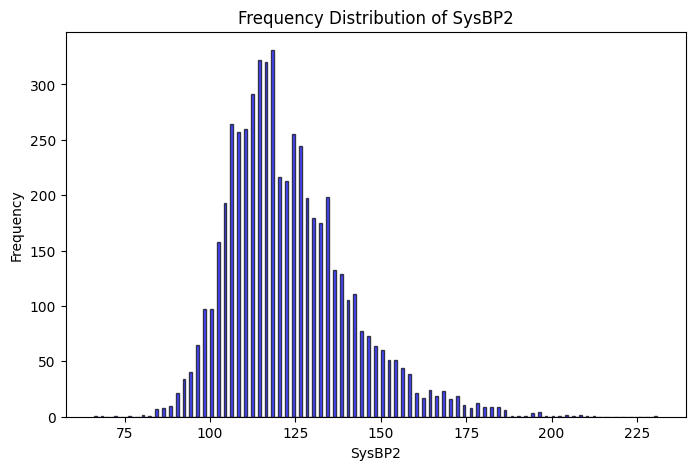

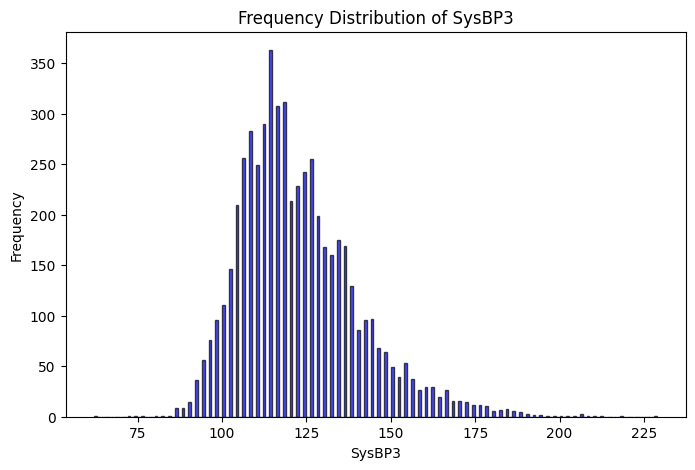

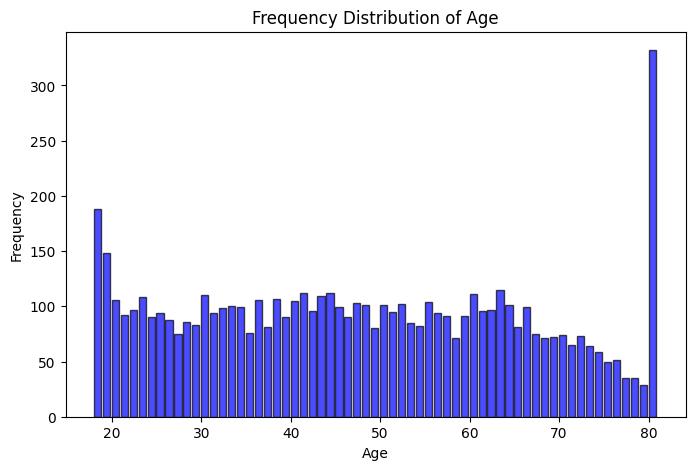

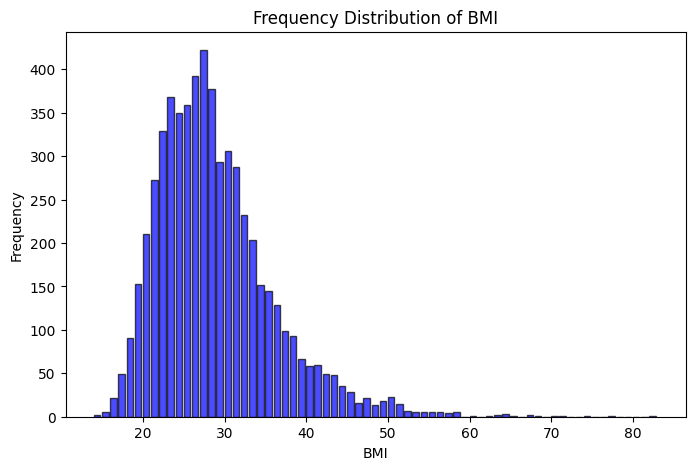

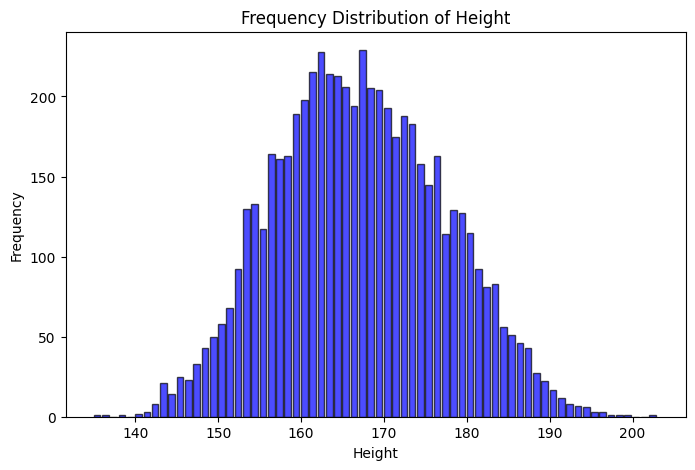

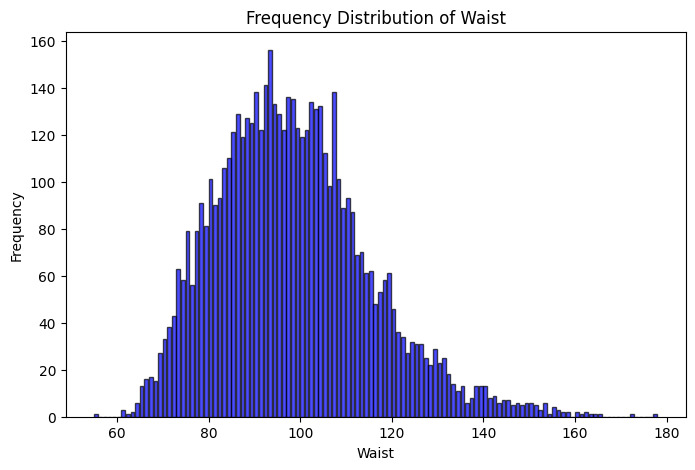

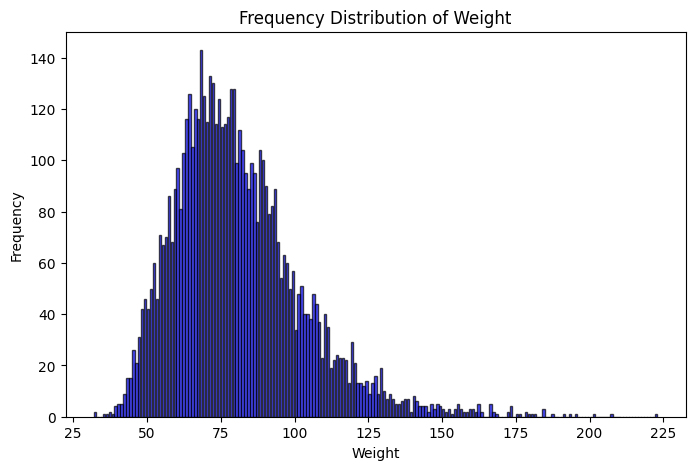

In [42]:
other_features = ['DiasBP1','DiasBP2','DiasBP3','SysBP1','SysBP2','SysBP3','Age', 'BMI','Height','Waist','Weight']
plot_feature_distribution(df, other_features, 1000000)